<a href="https://colab.research.google.com/github/Abdulmathin-shaik/Kaggle/blob/main/Cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torchvision import models
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# prompt: import cifar-10 from torch datasets

from torchvision.datasets import CIFAR10


In [16]:
# prompt: load the CIFAR10 datainto loaders

# Set up transformations for the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training dataset
trainset = CIFAR10(root='./data', train=True,
                   download=True, transform=transform)

# Create a DataLoader for the training data
trainloader = DataLoader(trainset, batch_size=32,
                         shuffle=True, num_workers=2)

# Load the testing dataset
testset = CIFAR10(root='./data', train=False,
                  download=True, transform=transform)

# Create a DataLoader for the testing data
testloader = DataLoader(testset, batch_size=32,
                        shuffle=False, num_workers=2)

# Define the classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

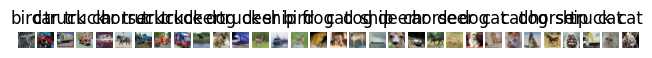

In [17]:
# prompt: visualize few images from train

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
plt.figure(figsize=(8, 4))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    img = images[i] / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

In [18]:
# Load pre-trained MobileNetV2
mobilenetv2 = models.mobilenet_v2(pretrained=True)
# Modify the classifier for CIFAR-10 (10 classes)
mobilenetv2.classifier[1] = nn.Linear(mobilenetv2.classifier[1].in_features, 10)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
mobilenetv3 = models.mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
mobilenetv3.classifier[3] = nn.Linear(mobilenetv3.classifier[3].in_features, 10)

In [24]:
def train_model(model, trainloader, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = correct_predictions / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    print('Finished Training')
    return train_losses, train_accuracies

In [25]:
import time

def evaluate_model(model, testloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct_predictions = 0
    total_samples = 0
    start_time = time.time()

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    end_time = time.time()
    accuracy = correct_predictions / total_samples
    inference_time = end_time - start_time

    print(f'Accuracy on the test set: {accuracy:.4f}')
    print(f'Inference time on the test set: {inference_time:.4f} seconds')

    return accuracy, inference_time

In [26]:
# --- Train and Evaluate MobileNetV2 ---
print("--- Training MobileNetV2 ---")
criterion_v2 = nn.CrossEntropyLoss()
optimizer_v2 = optim.Adam(mobilenetv2.parameters(), lr=0.001)
train_losses_v2, train_accuracies_v2 = train_model(mobilenetv2, trainloader, criterion_v2, optimizer_v2)
print("--- Evaluating MobileNetV2 ---")
accuracy_v2, inference_time_v2 = evaluate_model(mobilenetv2, testloader)

# --- Train and Evaluate MobileNetV3 ---
print("\n--- Training MobileNetV3 Large ---")
criterion_v3 = nn.CrossEntropyLoss()
optimizer_v3 = optim.Adam(mobilenetv3.parameters(), lr=0.001)
train_losses_v3, train_accuracies_v3 = train_model(mobilenetv3, trainloader, criterion_v3, optimizer_v3)
print("--- Evaluating MobileNetV3 Large ---")
accuracy_v3, inference_time_v3 = evaluate_model(mobilenetv3, testloader)

--- Training MobileNetV2 ---
Epoch 1, Loss: 0.7952, Accuracy: 0.7304
Epoch 2, Loss: 0.6678, Accuracy: 0.7720
Epoch 3, Loss: 0.6121, Accuracy: 0.7928
Epoch 4, Loss: 0.5755, Accuracy: 0.8066
Epoch 5, Loss: 0.5482, Accuracy: 0.8129
Epoch 6, Loss: 0.5185, Accuracy: 0.8248
Epoch 7, Loss: 0.4948, Accuracy: 0.8334
Epoch 8, Loss: 0.4776, Accuracy: 0.8381
Epoch 9, Loss: 0.4624, Accuracy: 0.8421
Epoch 10, Loss: 0.4484, Accuracy: 0.8472
Epoch 11, Loss: 0.4412, Accuracy: 0.8496
Epoch 12, Loss: 0.4219, Accuracy: 0.8564
Epoch 13, Loss: 0.4195, Accuracy: 0.8572
Epoch 14, Loss: 0.4008, Accuracy: 0.8618
Epoch 15, Loss: 0.3937, Accuracy: 0.8649
Epoch 16, Loss: 0.3950, Accuracy: 0.8665
Epoch 17, Loss: 0.3813, Accuracy: 0.8693
Epoch 18, Loss: 0.3771, Accuracy: 0.8717
Epoch 19, Loss: 0.3675, Accuracy: 0.8740
Epoch 20, Loss: 0.3632, Accuracy: 0.8751
Epoch 21, Loss: 0.3595, Accuracy: 0.8764
Epoch 22, Loss: 0.3649, Accuracy: 0.8747
Epoch 23, Loss: 0.3602, Accuracy: 0.8780
Epoch 24, Loss: 0.3593, Accuracy: 0.8